Configure notebook...

In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/work/git/isaac-demo/ipynb'

Imports

In [2]:
from pathlib import Path
import datetime
import pandas as pd
from IPython.display import IFrame, HTML, Markdown, Image, display

Define benchmark

In [3]:
OUT_DIR_BASE = "../out"
BENCH = "embench/nettle-aes"
DATE = "latest"

Lookup directories

In [4]:
BENCH_DIR = Path(OUT_DIR_BASE) / BENCH
print("BENCH_DIR", BENCH_DIR)
assert BENCH_DIR.is_dir()
if DATE == "latest":
    dates = [f for f in BENCH_DIR.iterdir() if f.is_dir()]
    assert len(dates) > 0
    if len(dates) == 1:
        DATE = dates[0].name
    else:
        sorted_dates = sorted(dates, key=lambda x: datetime.datetime.strptime(x.name, "%Y%m%dT%H%M%S"))
        DATE = sorted_dates[-1].name
DATE_DIR = BENCH_DIR / DATE
assert DATE_DIR.is_dir()

print(f"Picked date: {DATE}")
print(f"Directory: {DATE_DIR}")

RUN = DATE_DIR / "run"
SESS = DATE_DIR / "sess"
WORK = DATE_DIR / "work"

PLOTS_DIR = SESS / "plots"

BENCH_DIR ../out/embench/nettle-aes
Picked date: 20250303T214552
Directory: ../out/embench/nettle-aes/20250303T214552


Check baseline benchmark (ISS)

In [5]:
REPORT = RUN / "report.csv"

COLS = ["Model", "Run Instructions", "Total ROM", "Total RAM"]
pd.read_csv(REPORT)[COLS]

,Model,Run Instructions,Total ROM,Total RAM
0,nettle-aes,3573210,56672,4216


## Trace Analysis

### Identification of Bottlenecks

Per basic-block

In [6]:
IFrame(PLOTS_DIR / "runtime_per_llvm_bb.jpg", 700, 350)

Per function

In [7]:
IFrame(PLOTS_DIR / "runtime_per_func.jpg", 700, 350)

Per library

In [8]:
IFrame(PLOTS_DIR / "runtime_per_library.jpg", 700, 350)

Per object

In [9]:
IFrame(PLOTS_DIR / "runtime_per_object.jpg", 700, 350)

### Analyze instruction types

Per major opcode

In [10]:
IFrame(PLOTS_DIR / "runtime_per_opcode.jpg", 700, 350)

Per instruction name

In [11]:
IFrame(PLOTS_DIR / "runtime_per_instr.jpg", 700, 350)

### Choose BBs for ISE identification

In [12]:
CHOICES = SESS / "table" / "choices.pkl"

choices_df = pd.read_pickle(CHOICES)
choices_df

,func_name,file,bb_name,rel_weight,num_instrs,freq
0,_nettle_aes_decrypt,/work/git/isaac-demo/install/mlonmcu/deps/src/...,%bb.6,0.395024,87,16224.0
1,_nettle_aes_encrypt,/work/git/isaac-demo/install/mlonmcu/deps/src/...,%bb.6,0.395024,87,16224.0


In [13]:
num_choices = len(choices_df)
choices_sum_weights = choices_df["rel_weight"].sum()
max_num_instrs = choices_df["num_instrs"].max()
num_choices, choices_sum_weights, max_num_instrs

(2, 0.7900473892531932, 87)

## Identification of ISE candidates

### Per Func+BB

Filtered candidates

,Label,Count
0,Iso,2780
1,Filtered (I/O),178
2,Filtered (Mem),107
3,Selected,12
4,Filtered (Operands),4


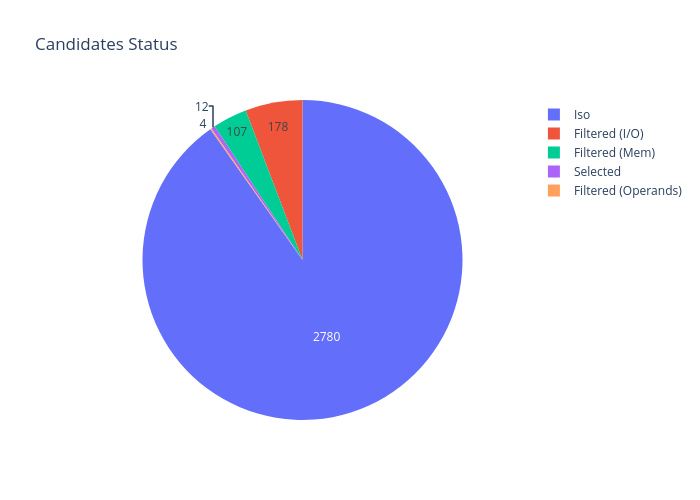

,Label,Count
0,Iso,2688
1,Filtered (I/O),246
2,Filtered (Mem),129
3,Selected,12
4,Filtered (Operands),4
5,Filtered (Weights),2


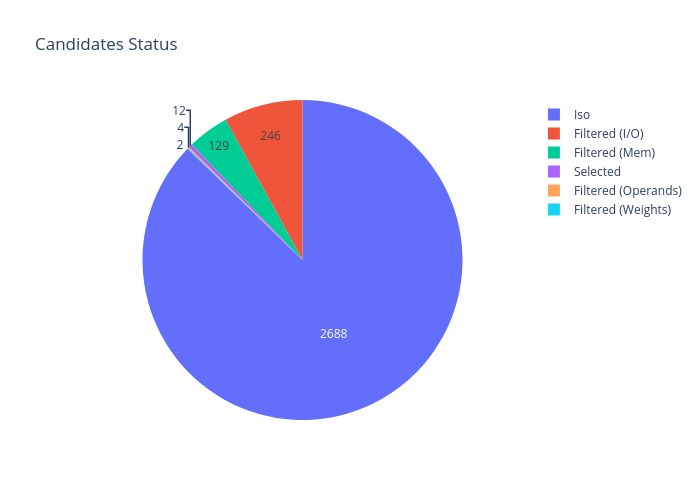

In [14]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    pie_csv = func_bb_dir / "pie.csv"
    pie_img = func_bb_dir / "pie.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie_csv))
    display(Image(pie_img))

Generated variations 

,Label,Count
0,Unknown,3081


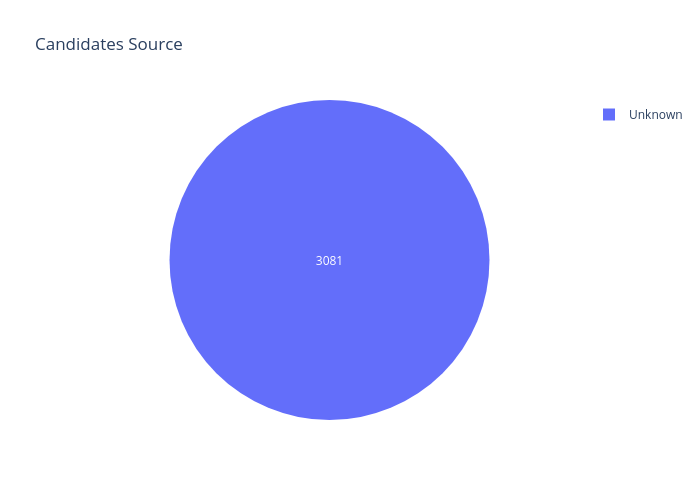

,Label,Count
0,Unknown,3081


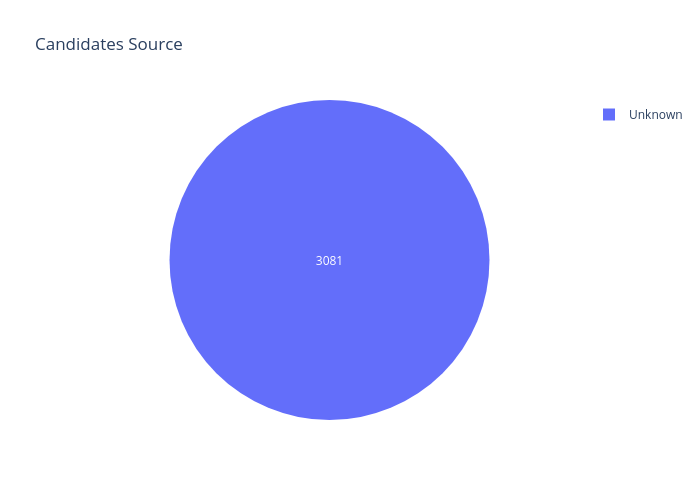

In [15]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: check suffix?
    pie2_csv = func_bb_dir / "pie2.csv"
    pie2_img = func_bb_dir / "pie2.png"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(pie2_csv))
    display(Image(pie2_img))

Profile

In [16]:
for _, row_data in choices_df.iterrows():
    func_name = row_data["func_name"]
    bb_name = row_data["bb_name"]
    func_bb_dir = WORK / f"{func_name}_{bb_name}_0"  # TODO: chekc suffix?
    times_csv = func_bb_dir / "times.csv"
    display(HTML(f"<h2>Func: {func_name}, BB: {bb_name}</h2>"))
    display(pd.read_csv(times_csv))

,Name,Secs,Secs (rel.)
0,Settings Validation,0.000080,8.395026e-07
1,Connect to DB,0.000178,1.864551e-06
2,Query func from DB,0.004465,4.684591e-05
3,Query candidates from DB,0.007922,8.311471e-05
4,Conversion to NX (func),0.196824,2.065028e-03
5,Conversion to NX (candidates),2.715239,2.848760e-02
6,Subgraph Generation,53.861820,5.651047e-01
7,Relabeling,0.479178,5.027416e-03
8,Dumping GF graph,0.064129,6.728299e-04
9,I/O Analysis,4.992989,5.238519e-02


,Name,Secs,Secs (rel.)
0,Settings Validation,0.000084,2.076225e-06
1,Connect to DB,0.000184,4.518234e-06
2,Query func from DB,0.004383,1.078899e-04
3,Query candidates from DB,0.007486,1.842836e-04
4,Conversion to NX (func),0.188053,4.629216e-03
5,Conversion to NX (candidates),2.762123,6.799409e-02
6,Subgraph Generation,0.089389,2.200446e-03
7,Relabeling,0.462491,1.138495e-02
8,Dumping GF graph,0.044147,1.086742e-03
9,I/O Analysis,5.001855,1.231287e-01


### Query Metrics

In [31]:
combined_query_metrics_file = WORK / "combined_query_metrics.csv"
pd.read_csv(combined_query_metrics_file)

FileNotFoundError: [Errno 2] No such file or directory: '../out/embench/nettle-aes/20250303T214552/work/combined_query_metrics.csv'

### Combined results

Pairwise overlaps

In [17]:
overlaps_file = WORK / "overlaps.csv"
pd.read_csv(overlaps_file)

,x,y,nodes,size
0,0,1,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}",11


Venn diagram

In [18]:
venn_file = WORK / "venn.jpg"
if len(choices_df) in [2, 3]:
    if venn_file.is_file():
        display(IFrame(venn_file, 700, 350))

Sankey diagram (duplicates vs. unqiue instructions)

In [19]:
sankey_file =  WORK / "sankey.md"
with open(sankey_file, "r") as f:
    content = f.read()
display(Markdown(content))


```mermaid
---
config:
  sankey:
    showValues: true
---
sankey-beta

%% source,target,value
Set0,Merged,12
Set1,Merged,12
Merged,Duplicates,11
Merged,Unique,13
Unique,Topk,13

```


### Analyse combined index

In [20]:
combined_index_yaml = WORK / "combined_index.yml"
names_csv = WORK / "names.csv"
names_df = pd.read_csv(names_csv)
num_candidates = len(names_df)
names_df

,instr,instr_lower
0,CUSTOM0,custom0
1,CUSTOM1,custom1
2,CUSTOM2,custom2
3,CUSTOM3,custom3
4,CUSTOM4,custom4
5,CUSTOM5,custom5
6,CUSTOM6,custom6
7,CUSTOM7,custom7
8,CUSTOM8,custom8
9,CUSTOM9,custom9


In [21]:
import yaml
with open(combined_index_yaml, "r") as f:
    combined_index_data = yaml.safe_load(f)

In [22]:
temp = combined_index_data["global"]["properties"]
filtered = list(filter(lambda x: x["candidate_count"] > 0, temp))
func_bbs_with_candidates = [(x["func"], x["bb"]) for x in filtered]
func_bbs_with_candidates_weights = [choices_df.where((choices_df["func_name"] == x[0]) & (choices_df["bb_name"] == x[1])).dropna()["rel_weight"].sum() for x in func_bbs_with_candidates]
func_bbs_with_candidates_weights_sum = sum(func_bbs_with_candidates_weights)
len(filtered), func_bbs_with_candidates_weights_sum

(2, 0.7900473892531932)

Analyze Encoding Footprint

In [23]:
import sys
sys.path.append("../scripts/")
from analyze_encoding import collect_weights, get_enc_weights_df, plot_enc_pie_multi, get_enc_score_df

In [24]:
enc_size = 32

total_weight, weight_per_instr, footprint_per_instr, rest_weight, bits_per_instr = collect_weights(combined_index_data, enc_size=enc_size)
enc_weights_df = get_enc_weights_df(total_weight, weight_per_instr, bits_per_instr, footprint_per_instr)
# enc_weights_df
enc_score_df = get_enc_score_df(enc_weights_df)
enc_score_df

,instr,bits,footprint,weight,enc_score
0,CUSTOM0,20.0,0.8,0.007812,0.992188
1,CUSTOM1,15.0,0.6,0.000244,0.999756
2,CUSTOM2,15.0,0.6,0.000244,0.999756
3,CUSTOM3,15.0,0.6,0.000244,0.999756
4,CUSTOM4,15.0,0.6,0.000244,0.999756
5,CUSTOM5,15.0,0.6,0.000244,0.999756
6,CUSTOM6,15.0,0.6,0.000244,0.999756
7,CUSTOM7,15.0,0.6,0.000244,0.999756
8,CUSTOM8,10.0,0.4,0.000008,0.999992
9,CUSTOM9,10.0,0.4,0.000008,0.999992


In [25]:
total_weight

0.017364501953125

Pie chart for enc weights (total and per custom instruction)

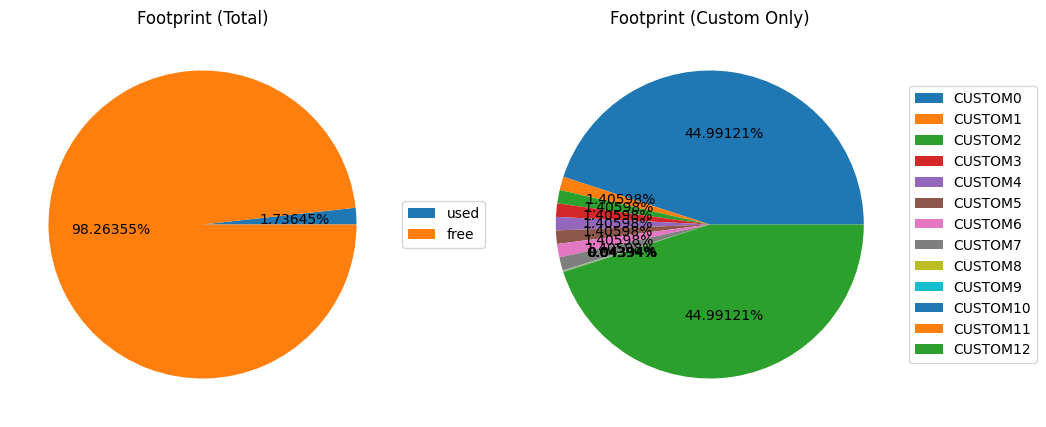

In [26]:
_ = plot_enc_pie_multi(weight_per_instr, rest_weight=rest_weight)

Number of candidates

In [27]:
num_candidates

13

## Analyze Graphs

In [30]:
dot_files = [Path(candidate_data["artifacts"]["io_sub"].replace(".pkl", ".dot")) for candidate_data in combined_index_data["candidates"]]
# dot_files

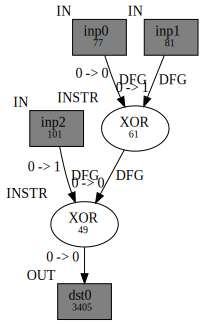

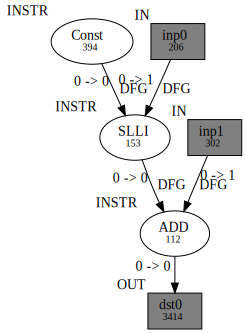

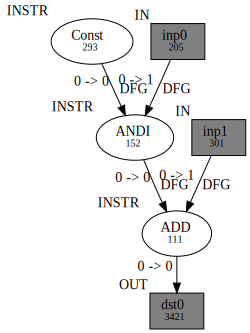

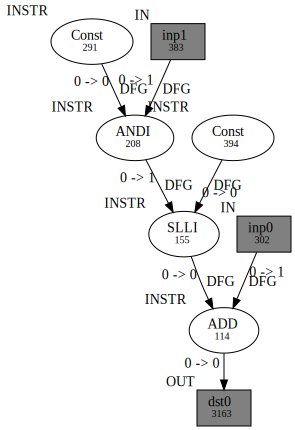

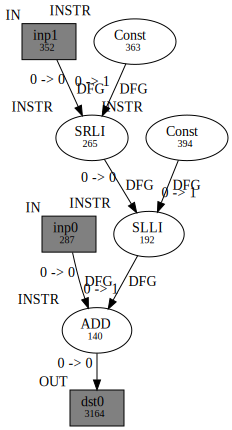

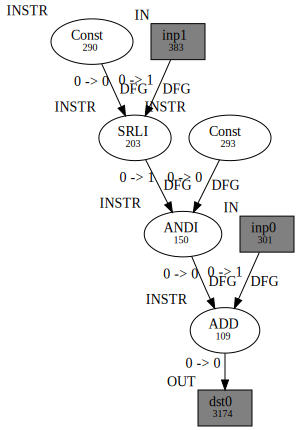

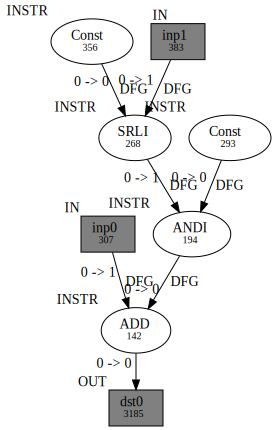

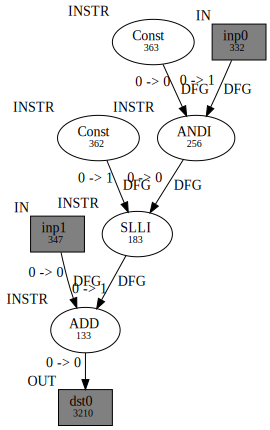

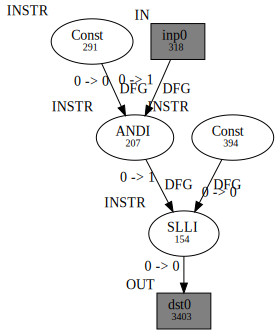

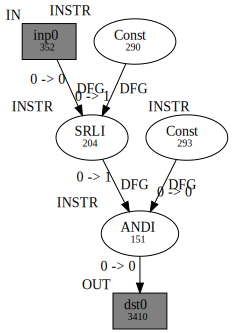

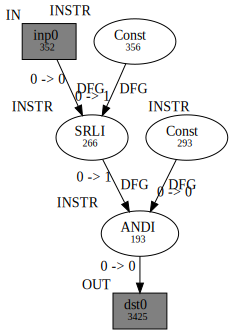

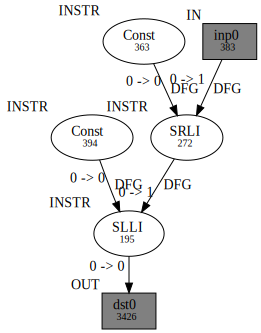

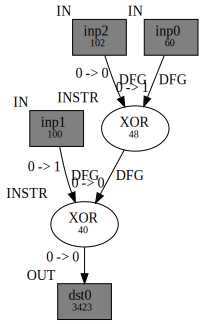

In [29]:
import graphviz

for i, dot_file in enumerate(dot_files):
    display(HTML(f"<h3>ID: {i}, File: {dot_file.name}</h3>"))
    with open(dot_file) as f:
        dot_graph = f.read()
    display(graphviz.Source(dot_graph))

## Generation of Instruction Set

Investigate generated Flat (unfused) CoreDSL per instruction

In [40]:
gen_dir = WORK / "gen"
for file in gen_dir.glob("*.flat"):
    display(HTML(f"<h3>File: {file.name}</h3>"))
    with open(file, "r") as f:
        code = f.read()
    display(Markdown(f"```c\n{code}\n```"""))

```c
// DateTime: 20250303T224105, Sub: 2, Name: name2, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(ANDI((1020),rs1_val)),rs2_val));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 8, Name: name8, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SLLI((2),(unsigned<32>)(ANDI((255),rs1_val))));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 4, Name: name4, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs1_val,(unsigned<32>)(SLLI((unsigned<32>)(SRLI(rs2_val,(24))),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 10, Name: name10, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ANDI((1020),(unsigned<32>)(SRLI(rs1_val,(14)))));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 0, Name: name0, Inputs: 3, Outputs: 1
unsigned<32> rs3_val=X[rs3];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(XOR((unsigned<32>)(XOR(rs1_val,rs2_val)),rs3_val));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 9, Name: name9, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ANDI((1020),(unsigned<32>)(SRLI(rs1_val,(6)))));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 6, Name: name6, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(ANDI((1020),(unsigned<32>)(SRLI((14),rs2_val)))),rs1_val));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 5, Name: name5, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(ANDI((1020),(unsigned<32>)(SRLI((6),rs2_val)))),rs1_val));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 12, Name: name12, Inputs: 3, Outputs: 1
unsigned<32> rs3_val=X[rs3];
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(XOR((unsigned<32>)(XOR(rs3_val,rs1_val)),rs2_val));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 3, Name: name3, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SLLI((2),(unsigned<32>)(ANDI((255),rs2_val)))),rs1_val));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 1, Name: name1, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD((unsigned<32>)(SLLI((2),rs1_val)),rs2_val));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224147, Sub: 7, Name: name7, Inputs: 2, Outputs: 1
unsigned<32> rs2_val=X[rs2];
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(ADD(rs2_val,(unsigned<32>)(SLLI((unsigned<32>)(ANDI((255),rs1_val)),(2)))));
X[rd]=outp0;
```

```c
// DateTime: 20250303T224105, Sub: 11, Name: name11, Inputs: 1, Outputs: 1
unsigned<32> rs1_val=X[rs1];
unsigned<32> outp0=(unsigned<32>)(SLLI((2),(unsigned<32>)(SRLI((24),rs1_val))));
X[rd]=outp0;
```

CoreDSL Set with automatic encoding

In [67]:
set_file = WORK / "XIsaac.core_desc"

with open(set_file, "r") as f:
    code = f.read()

display(Markdown(f"```c\n{code}\n```"""))

```c
import "/work/git/isaac-demo/etiss_arch_riscv/rv_base/RVI.core_desc"

InstructionSet XIsaac extends RV32I {
    instructions {
        CUSTOM0 {
            encoding: 2'b00 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom0", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs1_val) * (signed<32>)(rs2_val))))) + (signed<32>)(rs3_val))));
                X[rd] = outp0;
            }
        }
        CUSTOM1 {
            encoding: 2'b01 :: rs3[4:0] :: rs2[4:0] :: rs1[4:0] :: 3'b000 :: rd[4:0] :: 7'b1111011;
            assembly: {"custom1", "{name(rd)}, {name(rs1)}, {name(rs2)}, {name(rs3)}"};
            behavior: {
                unsigned<32> rs1_val = X[rs1];
                unsigned<32> rs2_val = X[rs2];
                unsigned<32> rs3_val = X[rs3];
                unsigned<32> outp0 = (unsigned<32>)((((signed<32>)((unsigned<32>)((((signed<32>)(rs3_val) * (signed<32>)(rs2_val))))) + (signed<32>)(rs1_val))));
                X[rd] = outp0;
            }
        }
    }
}


```

## LLVM Retargeting

## Seal5 Reports

In [68]:
reports_dir = WORK / "docker" / "seal5_reports"

### Properties

In [69]:
properties_csv = reports_dir / "properties.csv"
pd.read_csv(properties_csv)

,model,set,xlen,is_rv32,is_rv64,instr,enc_size,is_compressed,enc_format,opcode,...,is_simo,has_imm_leaf,has_side_effects,may_load,may_store,is_terminator,is_branch,skip_pattern_gen,uses_custom_reg,defs_custom_reg
0,XIsaac,XIsaac,32,True,False,CUSTOM0,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False
1,XIsaac,XIsaac,32,True,False,CUSTOM1,32,False,r-type (binop),custom-3,...,False,False,False,False,False,False,False,False,False,False


### Stage Times

In [70]:
stage_times_csv = reports_dir / "stage_times.csv"
pd.read_csv(stage_times_csv)[["stage", "time_s"]].dropna()

,stage,time_s
0,setup,35.539762
1,patch,17.859965
2,build,853.712861
3,transform,1.348287
4,generate,1.466015
5,patch,11.518617
6,build,63.740554
7,build,7.555806
8,build,7.492800
9,generate,1.240102


### Passes

In [71]:
seal5_status_csv = reports_dir / "status.csv"
seal5_status_compact_csv = reports_dir / "status_compact.csv"
seal5_status_df = pd.read_csv(seal5_status_csv)
seal5_status_compact_df = pd.read_csv(seal5_status_compact_csv)
seal5_status_compact_df

,model,set,xlen,instr,n_success,n_skipped,n_failed,n_total,status
0,XIsaac,XIsaac,32,CUSTOM0,14,0,0,14,good
1,XIsaac,XIsaac,32,CUSTOM1,14,0,0,14,good


### Test Results/Coverage

In [72]:
# test_coverage_compact_csv = reports_dir / "test_coverage_compact.csv"
# pd.read_csv(test_coverage_compact_csv)

In [73]:
# test_results_compact_csv = reports_dir / "test_results_compact.csv"
# pd.read_csv(test_results_compact_csv)

### Changed Files/Lines

In [74]:
seal5_diff_csv = reports_dir / "diff.csv"
seal5_diff_df = pd.read_csv(seal5_diff_csv)
seal5_diff_df

,phase,n_files_changed,n_insertions,n_deletions
0,PHASE_0,32,4604,5
1,PHASE_1,3,15,0
2,PHASE_2,4,96,0
3,PHASE_3,0,0,0
4,PHASE_4,3,22,0
5,PHASE_5,0,0,0
6,*,38,4737,5


In [75]:
seal5_diff_csv

PosixPath('../out/rnnoise_INT8/20250130T102419/work/docker/seal5_reports/diff.csv')

### Seal5 Score

In [76]:
seal5_score_data = []
seal5_pattern_gen_status_df = seal5_status_df[seal5_status_df["pass"] == "generate_passes.pattern_gen.behav_to_pat"][["instr", "status"]]
seal5_passes_status_df = seal5_status_compact_df[["instr", "status"]]
# print("seal5_passes_status_df", seal5_passes_status_df)
for instr_name in seal5_status_df["instr"].unique():
    # print("instr_name", instr_name)
    passes_status = seal5_passes_status_df[seal5_passes_status_df["instr"] == instr_name]
    assert len(passes_status) == 1
    passes_status = passes_status["status"].iloc[0]
    passes_score = 1.0 if passes_status == "good" else (0.5 if passes_status == "ok" else 0.0)
    
    pattern_gen_status = seal5_pattern_gen_status_df[seal5_pattern_gen_status_df["instr"] == instr_name]
    assert len(pattern_gen_status) == 1
    pattern_gen_status = pattern_gen_status["status"].iloc[0]
    # print("pattern_gen_status", pattern_gen_status)
    pattern_gen_score = 1.0 if pattern_gen_status == "success" else -1.0
    # print("pattern_gen_score", pattern_gen_score)
    
    new = {"instr": instr_name, "pattern_gen_score": pattern_gen_score, "passes_score": passes_score}
    seal5_score_data.append(new)
    
def calc_seal5_score(x):
    return x.min()

seal5_score_df = pd.DataFrame(seal5_score_data)
seal5_score_df["seal5_score"] =  seal5_score_df[["pattern_gen_score", "passes_score"]].apply(calc_seal5_score, axis=1)
seal5_score_df
# TODO: write to file

,instr,pattern_gen_score,passes_score,seal5_score
0,CUSTOM0,1.0,1.0,1.0
1,CUSTOM1,1.0,1.0,1.0


## ISS Evaluation

In [77]:
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,rnnoise_INT8,rv32imfd,570276,1.000000
1,rnnoise_INT8,rv32imfd_xisaac,445022,0.780362


In [78]:
#TEMP
RUN_COMPARE = Path(str(RUN) + "_compare")
REPORT_COMPARE = RUN_COMPARE / "report.csv"

COLS = ["Model", "Arch", "Run Instructions", "Run Instructions (rel.)"]
bench_compare_df = pd.read_csv(REPORT_COMPARE)[COLS]
bench_compare_df

,Model,Arch,Run Instructions,Run Instructions (rel.)
0,rnnoise_INT8,rv32imfd,570276,1.000000
1,rnnoise_INT8,rv32imfd_xisaac,445022,0.780362


In [79]:
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,rnnoise_INT8,rv32imfd,283504,3636,104892,1.000000
1,rnnoise_INT8,rv32imfd_xisaac,282576,3636,103964,0.991153


In [80]:
# temp
RUN_COMPARE_MEM = Path(str(RUN) + "_compare_mem")
REPORT_COMPARE_MEM = RUN_COMPARE_MEM / "report.csv"

COLS = ["Model", "Arch", "Total ROM", "Total RAM", "ROM code", "ROM code (rel.)"]
bench_compare_mem_df = pd.read_csv(REPORT_COMPARE_MEM)[COLS]
bench_compare_mem_df

,Model,Arch,Total ROM,Total RAM,ROM code,ROM code (rel.)
0,rnnoise_INT8,rv32imfd,283504,3636,104892,1.000000
1,rnnoise_INT8,rv32imfd_xisaac,282576,3636,103964,0.991153


### MLonMCU Score (Set)

In [81]:
assert len(bench_compare_df) == 2
run_instrs_rel = bench_compare_df["Run Instructions (rel.)"].iloc[-1]
assert len(bench_compare_mem_df) == 2
rom_code_rel = bench_compare_mem_df["ROM code (rel.)"].iloc[-1]

run_instrs_score = 1.0/run_instrs_rel-1
rom_code_score = 1.0/rom_code_rel-1

# TODO: cycles!

RUN_INSTR_WEIGHT_POS = 2
ROM_CODE_WEIGHT_POS = 1
RUN_INSTR_WEIGTH_NEG = 10
ROM_CODE_WEIGHT_NEG = 2

mlonmcu_set_score_data = [{"set": "XIsaac", "run_instrs_score": run_instrs_score, "rom_code_score": rom_code_score}]

def calc_mlonmcu_score(x):
    # return gmean([x["run_instrs_score"], x["rom_code_score"]], weights=[RUN_INSTR_WEIGHT, ROM_CODE_WEIGHT])
    a = x["run_instrs_score"]
    a = a * RUN_INSTR_WEIGHT_POS if a > 0 else a * RUN_INSTR_WEIGTH_NEG
    print(a)
    b = x["rom_code_score"]
    b = b * ROM_CODE_WEIGHT_POS if b > 0 else b * ROM_CODE_WEIGHT_NEG
    print(b)
    temp = a + b
    return max(-1.0, min(1.0, temp))

mlonmcu_set_score_df = pd.DataFrame(mlonmcu_set_score_data)
mlonmcu_set_score_df["mlonmcu_score"] =  mlonmcu_set_score_df[["run_instrs_score", "rom_code_score"]].apply(calc_mlonmcu_score, axis=1)
mlonmcu_set_score_df
# TODO: write to file

0.562911496510285
0.008926166750028885


,set,run_instrs_score,rom_code_score,mlonmcu_score
0,XIsaac,0.281456,0.008926,0.571838


## Dynamic Analysis

In [82]:
SESS_NEW = DATE_DIR / "sess_new"
PLOTS_DIR_NEW = SESS_NEW / "plots"

In [83]:
IFrame(PLOTS_DIR_NEW / "runtime_per_llvm_bb.jpg", 700, 350)

In [84]:
IFrame(PLOTS_DIR_NEW / "runtime_per_func.jpg", 700, 350)

In [85]:
IFrame(PLOTS_DIR_NEW / "runtime_per_opcode.jpg", 700, 350)

In [86]:
IFrame(PLOTS_DIR_NEW / "runtime_per_instr.jpg", 700, 350)

In [87]:
opcodes_hist_file = SESS_NEW / "table" / "opcodes_hist.pkl"
opcodes_hist_df = pd.read_pickle(opcodes_hist_file)
print("All opcodes:")
display(opcodes_hist_df)
print("Custom only:")
display(opcodes_hist_df[opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])

All opcodes:


,opcode,count,rel_count
0,LOAD,151850,0.330188
1,custom-3/rv128,126648,0.275388
2,OP-IMM,59767,0.129960
3,BRANCH,30186,0.065638
4,OP-FP,19591,0.042599
5,OP,16645,0.036194
6,STORE,10512,0.022858
7,LUI,9862,0.021444
8,LOAD-FP,7537,0.016389
9,OP-IMM (Compressed),4542,0.009876


Custom only:


,opcode,count,rel_count
1,custom-3/rv128,126648,0.275388


In [88]:
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

All instructions:


,instr,count,rel_count
0,lh,140168,0.304787
1,custom0,126648,0.275388
2,addi,50378,0.109544
3,bne,18053,0.039255
4,lui,9862,0.021444
...,...,...,...
91,ori,11,0.000024
92,csrai,6,0.000013
93,sll,2,0.000004
94,csrrw,1,0.000002


Custom only:


,instr,count,rel_count
1,custom0,126648,0.275388


In [89]:
# temp
instrs_hist_file = SESS_NEW / "table" / "instrs_hist.pkl"
instrs_hist_df = pd.read_pickle(instrs_hist_file)
print("All instructions:")
display(instrs_hist_df)
print("Custom only:")
custom_instrs_hist_df = instrs_hist_df[instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(custom_instrs_hist_df)

All instructions:


,instr,count,rel_count
0,lh,140168,0.304787
1,custom0,126648,0.275388
2,addi,50378,0.109544
3,bne,18053,0.039255
4,lui,9862,0.021444
...,...,...,...
91,ori,11,0.000024
92,csrai,6,0.000013
93,sll,2,0.000004
94,csrrw,1,0.000002


Custom only:


,instr,count,rel_count
1,custom0,126648,0.275388


In [90]:
dyn_counts_score_data = []

merged_custom_instrs_hist_df = pd.merge(names_df, custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = instrs_hist_df["count"].sum()
instr_count_max = instrs_hist_df["count"].max()
print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_custom_instrs_hist_df["count"].max()
print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    dyn_counts_score_data.append(new)

dyn_counts_score_df = pd.DataFrame(dyn_counts_score_data)
dyn_counts_score_df
# TODO: write to file

instr_count 459889 140168
custom_count 126648.0 126648.0


,instr,used_score,count_score,custom_count_score
0,CUSTOM0,1.0,0.903544,1.0
1,CUSTOM1,-1.0,-1.000000,-1.0


## Static Analysis

### Instructions

In [79]:
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,7082,0.177641
1,lw,5548,0.139163
2,addi,5027,0.126094
3,li,2156,0.054080
4,add,1355,0.033988
...,...,...,...
106,divu,1,0.000025
107,fneg.d,1,0.000025
108,fle.d,1,0.000025
109,rdcycle,1,0.000025


Custom only:


,instr,count,rel_count
20,custom0,430,0.010786


Pie:


In [80]:
# temp
disass_instrs_hist_file = SESS_NEW / "table" / "disass_instrs_hist.pkl"
disass_instrs_hist_df = pd.read_pickle(disass_instrs_hist_file)
print("All instructions:")
display(disass_instrs_hist_df)
print("Custom only:")
diass_custom_instrs_hist_df = disass_instrs_hist_df[disass_instrs_hist_df["instr"].apply(lambda x: "custom" in x)]
display(diass_custom_instrs_hist_df)
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_instr.jpg", 700, 350))

All instructions:


,instr,count,rel_count
0,sw,7082,0.177641
1,lw,5548,0.139163
2,addi,5027,0.126094
3,li,2156,0.054080
4,add,1355,0.033988
...,...,...,...
106,divu,1,0.000025
107,fneg.d,1,0.000025
108,fle.d,1,0.000025
109,rdcycle,1,0.000025


Custom only:


,instr,count,rel_count
20,custom0,430,0.010786


Pie:


In [81]:
static_counts_score_data = []

merged_diass_custom_instrs_hist_df = pd.merge(names_df, diass_custom_instrs_hist_df, how="outer", left_on="instr_lower", right_on="instr", suffixes=('', '_y'))

COUNT_WEIGHT = 1
CUSTOM_COUNT_WEIGHT = 1

instr_count_sum = disass_instrs_hist_df["count"].sum()
instr_count_max = disass_instrs_hist_df["count"].max()
# print("instr_count", instr_count_sum, instr_count_max)
custom_count_sum = merged_diass_custom_instrs_hist_df["count"].sum()
custom_count_max = merged_diass_custom_instrs_hist_df["count"].max()
# print("custom_count", custom_count_sum, custom_count_max)

for _, row_df in merged_diass_custom_instrs_hist_df.iterrows():
    instr = row_df["instr"]
    count = row_df["count"]
    # rel_count = row_df["rel_count"]
    used = count > 0
    used_score = 1.0 if used else -1.0
    count_score = count/instr_count_max if used else -1.0
    custom_count_score = count/custom_count_max if used else -1.0
    new = {"instr": instr, "used_score": used_score, "count_score": count_score, "custom_count_score": custom_count_score}
    static_counts_score_data.append(new)

static_counts_score_df = pd.DataFrame(static_counts_score_data)
static_counts_score_df
# TODO: write to file

,instr,used_score,count_score,custom_count_score
0,CUSTOM0,1.0,0.060717,1.0


### Opcodes

In [82]:
disass_opcodes_hist_file = SESS_NEW / "table" / "disass_opcodes_hist.pkl"
disass_opcodes_hist_df = pd.read_pickle(disass_opcodes_hist_file)
print("All instructions:")
display(disass_opcodes_hist_df)
print("Custom only:")
display(disass_opcodes_hist_df[disass_opcodes_hist_df["opcode"].apply(lambda x: "custom" in x)])
print("Pie:")
display(IFrame(PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg", 700, 350))

All instructions:


,opcode,count,rel_count
0,OP-IMM,7156,0.179497
1,STORE,7093,0.177917
2,LOAD,6110,0.153260
3,OP,3132,0.078561
4,OP-IMM (Compressed),2247,0.056362
5,BRANCH,2206,0.055334
6,JALR (Compressed),1718,0.043093
7,STORE (Compressed),1718,0.043093
8,LOAD (Compressed),1653,0.041463
9,OP-FP,1509,0.037851


Custom only:


,opcode,count,rel_count
17,custom-3/rv128,430,0.010786


Pie:


In [83]:
# TODO: write utilization to file


In [84]:
PLOTS_DIR_NEW / "disass_counts_per_opcode.jpg"

PosixPath('../out/rnnoise_INT8/20250129T100017/sess_new/plots/disass_counts_per_opcode.jpg')

## HLS Metrics

In [85]:
hls_metrics_csv = WORK / "docker" / "hls" / "hls_metrics.csv"
display(pd.read_csv(hls_metrics_csv))

FileNotFoundError: [Errno 2] No such file or directory: '../out/rnnoise_INT8/20250129T100017/work/docker/hls/hls_metrics.csv'

## HW Synthesis Metrics

In [ ]:
syn_best_csv = WORK / "docker" / "hls" / "syn_dir" / "best.csv"
display(pd.read_csv(syn_best_csv))

In [ ]:
syn_metrics_csv = WORK / "docker" / "hls" / "syn_metrics.csv"
display(pd.read_csv(syn_metrics_csv))
# TODO: store baseline (without ext)!

In [ ]:
# TODO: performance estimator?

## LOCs Overview

In [46]:
from locs_helper import get_combined_locs_df
get_combined_locs_df(seal5_diff_csv=seal5_diff_csv, etiss_patch_stat="../out/nettle-aes/20241202T160512/work/docker/etiss_patch.stat", hls_metrics_csv=hls_metrics_csv)

,step,n_files_changed,n_insertions,n_deletions
0,seal5,32,728.0,0
1,etiss,1,986.0,0
2,rtl,1,434.0,0
